# Brain Tumor Multi-Task Learning (Xception)
**Classification + Segmentation**

- Encoder: Xception (pretrained ImageNet)
- Decoder: U-Net with CBAM Attention
- Tasks: 4-class classification + Binary segmentation

In [1]:
!pip install -q segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.6 MB/s eta 0:00:00


## 1. Imports & Configuration

In [2]:
import os, gc, warnings
from typing import Dict, List, Tuple, Optional
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
class Config:
    # Duong dan den thu muc du lieu BRISC2025 tren Kaggle
    ROOT_DIR = '/kaggle/input/brisc2025/brisc2025'
    CLASS_DIR = os.path.join(ROOT_DIR, 'classification_task') # Thu muc chua anh cho bai toan phan loai
    SEG_DIR = os.path.join(ROOT_DIR, 'segmentation_task')     # Thu muc chua mask cho bai toan phan doan
    
    # Dinh nghia 4 loai khoi u
    CLASSES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
    NUM_CLASSES = 4
    
    # Kich thuoc anh dau vao toi uu cho Xception (299x299)
    # Luu y: EfficientNet thuong dung 300, Xception la 299
    IMG_SIZE = 299  
    
    # Kich thuoc Batch cho 2 giai doan huan luyen
    # Giam Batch Size xuong so voi EfficientNet vi Xception nang hon
    BATCH_SIZE_STAGE1, BATCH_SIZE_STAGE2 = 24, 12  
    
    # So Epoch cho Warm-up (Stage 1) va Fine-tuning (Stage 2)
    EPOCHS_STAGE1, EPOCHS_STAGE2 = 10, 50
    PATIENCE = 15 # So epoch doi Early Stopping
    
    # Ten Backbone Encoder su dung trong thu vien segmentation_models_pytorch
    ENCODER_NAME = "xception"  
    
    # Thiet lap thiet bi chay (GPU hoac CPU)
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42 # Seed de tai lap ket qua
    
    # Ham chuyen doi giua Ten lop va Index
    @classmethod
    def class_to_idx(cls): return {name: i for i, name in enumerate(cls.CLASSES)}
    @classmethod
    def idx_to_class(cls): return {i: name for i, name in enumerate(cls.CLASSES)}

def set_seed(seed=42):
    """Thiet lap seed cho Numpy va Torch de dam bao ket qua dong nhat"""
    np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

# Ap dung seed va in thong tin cau hinh
set_seed(Config.SEED)
print(f"Device: {Config.DEVICE}")
print(f"Encoder: {Config.ENCODER_NAME}")

Device: cuda
Encoder: xception


Kích thước ảnh 299x299 là tối ưu để tận dụng sức mạnh của backbone Xception.

Chiến lược giảm Batch Size (từ 24 xuống 12) ở giai đoạn Fine-tuning là cần thiết để tránh tràn bộ nhớ GPU do Xception có kiến trúc khá nặng.

Việc cố định Seed đảm bảo tính công bằng và chính xác khi so sánh hiệu năng với các mô hình khác.

## 2. Data Preparation

Quét thư mục tạo DataFrame chứa đường dẫn Ảnh, Mask và Nhãn

In [ ]:
def create_dataframe(mode='train'):
    class_path = os.path.join(Config.CLASS_DIR, mode)
    seg_mask_path = os.path.join(Config.SEG_DIR, mode, 'masks')
    mask_basenames = set()
    if os.path.exists(seg_mask_path):
        mask_basenames = {os.path.splitext(f)[0] for f in os.listdir(seg_mask_path)}
    
    data = []
    for cls_name in Config.CLASSES:
        cls_folder = os.path.join(class_path, cls_name)
        if not os.path.exists(cls_folder): continue
        for img_name in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, img_name)
            img_base = os.path.splitext(img_name)[0]
            mask_path = "NO_MASK"
            if img_base in mask_basenames:
                for ext in ['.png', '.jpg']:
                    candidate = os.path.join(seg_mask_path, img_base + ext)
                    if os.path.exists(candidate): mask_path = candidate; break
            data.append({'image_path': img_path, 'mask_path': mask_path, 
                        'label': Config.class_to_idx()[cls_name], 'filename': img_name})
    return pd.DataFrame(data)
#Tạo các tập Train, Val, Test hoàn chỉnh
def prepare_data():
    train_full = create_dataframe('train')
    test_df = create_dataframe('test')
    train_df, val_df = train_test_split(train_full, test_size=0.2, stratify=train_full['label'], random_state=Config.SEED)
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df

train_df, val_df, test_df = prepare_data()

Train: 4000, Val: 1000, Test: 1000


## 3. Dataset & Augmentation

In [ ]:
# ==========================================
# 1. CUSTOM DATASET CLASS
# ==========================================
class BRISCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 1. Lấy thông tin từ dòng thứ idx
        row = self.df.iloc[idx]
        
        # 2. Đọc ảnh và chuyển sang RGB (OpenCV mặc định là BGR)
        image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # 3. Xử lý Mask
        # Nếu không có mask (NO_MASK), tạo mask đen toàn bộ
        if row['mask_path'] == 'NO_MASK' or pd.isna(row['mask_path']):
            mask = np.zeros((h, w), dtype=np.float32)
        else:
            # Đọc mask dạng xám (grayscale)
            mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
            # Chuẩn hóa về 0 và 1 (Binary Mask)
            mask = (mask.astype(np.float32) / 255.0 > 0.5).astype(np.float32)
        
        # 4. Áp dụng Data Augmentation (nếu có)
        # Quan trọng: Albumentations sẽ biến đổi CẢ image và mask đồng bộ
        if self.transforms:
            aug = self.transforms(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']
        
        # 5. Chuyển mask về dạng Tensor chuẩn của PyTorch (Channel, Height, Width)
        # Thêm chiều channel nếu chưa có (H, W) -> (1, H, W)
        if isinstance(mask, torch.Tensor):
            mask = mask.unsqueeze(0) if mask.ndim == 2 else mask
        else:
            mask = torch.from_numpy(mask).unsqueeze(0)
        
        # Trả về: Ảnh, Mask, và Nhãn phân loại
        return image, mask, torch.tensor(row['label'], dtype=torch.long)
# ==========================================
# 2. DATA AUGMENTATION PIPELINES
# ==========================================
def get_train_transforms(size=299):
    """
    Chiến lược tăng cường dữ liệu MẠNH (Heavy Augmentation)
    để chống Overfitting cho mô hình Xception lớn.
    """
    return A.Compose([
        A.Resize(size, size),
        
        # --- Biến đổi hình học (Geometric) ---
        A.HorizontalFlip(p=0.5),      # Lật ngang
        A.VerticalFlip(p=0.4),        # Lật dọc
        A.RandomRotate90(p=0.5),      # Xoay 90 độ
        # Xoay nhẹ, giữ nền đen (value=0)
        A.Rotate(limit=35, p=0.6, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.ShiftScaleRotate(shift_limit=0.12, scale_limit=0.18, rotate_limit=25,
                          border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.6),
        
        # --- Biến dạng đàn hồi (Elastic Deformations) ---
        # Giả lập sự biến dạng của mô mềm, rất tốt cho ảnh y tế
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120*0.05, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
            A.GridDistortion(num_steps=5, distort_limit=0.3, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
            A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
        ], p=0.5),
        
        # --- Biến đổi cường độ (Intensity) ---
        # CLAHE: Cực kỳ quan trọng cho MRI để làm rõ chi tiết
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.6),
        A.RandomGamma(gamma_limit=(80, 125), p=0.4),
        
        # --- Nhiễu và Mờ (Noise/Blur) ---
        # Giúp mô hình bền vững với ảnh chất lượng thấp
        A.OneOf([A.GaussNoise(var_limit=(10, 50), p=1), A.GaussianBlur(blur_limit=(3, 5), p=1),
                 A.MedianBlur(blur_limit=3, p=1), A.MotionBlur(blur_limit=5, p=1)], p=0.35),
        
        # --- Regularization (Cắt bỏ thông tin) ---
        # Bắt mô hình nhìn vào toàn cảnh thay vì chỉ chăm chăm vào 1 điểm
        A.CoarseDropout(max_holes=10, max_height=size//10, max_width=size//10, min_holes=5, fill_value=0, mask_fill_value=0, p=0.35),
        A.GridDropout(ratio=0.25, unit_size_min=10, unit_size_max=30, fill_value=0, mask_fill_value=0, p=0.25),
        
        # --- Chuẩn hóa (Normalization) ---
        # Sử dụng Mean/Std của ImageNet vì Xception pre-trained trên đó
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
def get_val_transforms(size=299):
    """Pipeline cho Validation/Test: Chỉ Resize và Normalize"""
    return A.Compose([
        A.Resize(size, size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
def create_dataloaders(train_df, val_df, test_df, batch_size=24):
    """Tạo DataLoader để nạp dữ liệu vào GPU"""
    train_ds = BRISCDataset(train_df, get_train_transforms(Config.IMG_SIZE))
    val_ds = BRISCDataset(val_df, get_val_transforms(Config.IMG_SIZE))
    test_ds = BRISCDataset(test_df, get_val_transforms(Config.IMG_SIZE)) # Test dùng val_transforms
    
    # num_workers=2: Dùng 2 CPU core để load ảnh song song
    # pin_memory=True: Tăng tốc độ copy dữ liệu từ RAM sang VRAM GPU
    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
            DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
            DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2))

## 4. Model Architecture

Xception Backbone: Trích xuất đặc trưng cực tốt.

U-Net: Cho tác vụ phân đoạn (Segmentation).

CBAM (Convolutional Block Attention Module): Giúp mô hình "tập trung" vào vùng tổn thương quan trọng, bỏ qua nền nhiễu.

In [ ]:
# ==========================================
# 1. CÁC MODULE CHÚ Ý (ATTENTION MODULES - CBAM)
# ==========================================

class ChannelAttention(nn.Module):
    """
    Module Chú ý Kênh (Channel Attention):
    Giúp mô hình tập trung vào 'Cái gì' (What) quan trọng trong ảnh (ví dụ: kênh nào chứa thông tin khối u).
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Gom thông tin toàn bộ ảnh về 1 điểm
        # Mạng neural nhỏ (MLP) để học trọng số cho từng kênh
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False), nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False), nn.Sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.fc(self.avg_pool(x).view(b, c)).view(b, c, 1, 1)
        return x * y.expand_as(x) # Nhân trọng số vào input ban đầu

class SpatialAttention(nn.Module):
    """
    Module Chú ý Không gian (Spatial Attention):
    Giúp mô hình tập trung vào 'Ở đâu' (Where) trong ảnh (ví dụ: vị trí khối u nằm góc nào).
    """
    def __init__(self, kernel_size=7):
        super().__init__()
        # Gom Avg và Max pooling lại rồi dùng Conv2D 7x7 để tạo bản đồ nhiệt (heatmap)
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # Tạo mask chú ý không gian
        return x * self.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))

class CBAM(nn.Module):
    """
    Kết hợp Channel + Spatial Attention để tạo ra cơ chế chú ý toàn diện.
    """
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x): return self.sa(self.ca(x)) # Tuần tự: Chú ý Kênh -> Chú ý Không gian

# ==========================================
# 2. KIẾN TRÚC MÔ HÌNH ĐA NHIỆM (MULTI-TASK MODEL)
# ==========================================

class MultiTaskModelXception(nn.Module):
    """
    Mô hình Đa nhiệm sử dụng Xception làm Encoder và tích hợp CBAM Attention.
    Thực hiện song song 2 nhiệm vụ: Phân loại U (Classification) và Phân vùng U (Segmentation).
    """
    def __init__(self, num_classes=4, encoder_name="xception"):
        super().__init__()
        # 1. Khởi tạo U-Net với backbone Xception (Encoder)
        # Sử dụng thư viện segmentation_models_pytorch, pre-trained trên ImageNet
        # Output channels của Encoder Xception: [3, 64, 128, 256, 728, 2048]
        self.seg_model = smp.Unet(
            encoder_name=encoder_name, 
            encoder_weights="imagenet", 
            in_channels=3, 
            classes=1 # Output 1 kênh (Mask Binary)
        )
        
        # 2. Tích hợp CBAM vào Decoder của U-Net
        # Các kênh output của decoder (theo thứ tự từ sâu đến nông)
        decoder_channels = [256, 128, 64, 32, 16]
        # Tạo danh sách các module CBAM tương ứng với từng tầng decoder
        self.decoder_attentions = nn.ModuleList([CBAM(ch) for ch in decoder_channels])
        
        # 3. Xây dựng nhánh Phân loại (Classification Head)
        # Lấy số kênh output tầng sâu nhất của Encoder (Xception là 2048)
        encoder_channels = self.seg_model.encoder.out_channels[-1] 
        self.cls_attention = CBAM(encoder_channels) # Thêm CBAM để tăng cường đặc trưng phân loại
        self.pool = nn.AdaptiveAvgPool2d(1)
        
        # Mạng Dense (MLP) nhiều tầng để phân loại ra 4 lớp
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.BatchNorm1d(encoder_channels), 
            nn.Dropout(0.5), # Dropout mạnh tay (0.5) để chống Overfitting
            nn.Linear(encoder_channels, 512), 
            nn.SiLU(), # Hàm kích hoạt SiLU (Swish) hiện đại
            nn.BatchNorm1d(512), 
            nn.Dropout(0.4),
            nn.Linear(512, 256), 
            nn.SiLU(), 
            nn.Dropout(0.3), 
            nn.Linear(256, num_classes) # Output layer (4 classes)
        )
    
    def forward(self, x):
        # Bước 1: Encoder (Trích xuất đặc trưng)
        features = self.seg_model.encoder(x)
        
        # Bước 2: Nhánh Segmentation
        decoder_out = self.seg_model.decoder(features)
        # Áp dụng CBAM vào feature map cuối cùng của Decoder (kênh 16)
        decoder_out = self.decoder_attentions[-1](decoder_out)
        seg_mask = self.seg_model.segmentation_head(decoder_out)
        
        # Bước 3: Nhánh Classification
        # Lấy đặc trưng sâu nhất (features[-1]: 2048 kênh)
        cls_features = self.cls_attention(features[-1])
        cls_logits = self.classifier(self.pool(cls_features))
        
        return seg_mask, cls_logits
    
    # Hàm đóng băng Encoder (Giai đoạn 1: Warm-up)
    def freeze_encoder(self):
        for p in self.seg_model.encoder.parameters(): p.requires_grad = False
    
    # Hàm mở băng Encoder (Giai đoạn 2: Fine-tuning toàn bộ)
    def unfreeze_encoder(self):
        for p in self.seg_model.encoder.parameters(): p.requires_grad = True

In [ ]:
# Khoi tao model MultiTaskModelXception va dua vao thiet bi (CPU/GPU)
# Su dung config da khai bao truoc do: 4 lop phan loai, backbone Xception
model = MultiTaskModelXception(Config.NUM_CLASSES, Config.ENCODER_NAME).to(Config.DEVICE)

# In ten Encoder de kiem tra
print(f"Encoder: {Config.ENCODER_NAME}")

# In so luong kenh dau ra cua tung tang Encoder (feature maps)
# Day la thong tin quan trong de xay dung Decoder va Skip Connections
print(f"Encoder output channels: {model.seg_model.encoder.out_channels}")

# Tinh toan va in tong so luong tham so cua mo hinh (don vi trieu - M)
# Giup danh gia do phuc tap cua mo hinh va du doan bo nho VRAM can thiet
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/91.7M [00:00<?, ?B/s]

Encoder: xception
Encoder output channels: [3, 64, 128, 256, 728, 2048]
Parameters: 30.49M


Chuỗi kênh đầu ra [3, 64, 128, 256, 728, 2048] cho thấy kiến trúc phân cấp (hierarchical) đặc trưng. Tầng sâu nhất (Deepest Layer) có 2048 kênh, chứa đựng thông tin ngữ nghĩa (semantic) phong phú nhất, rất lý tưởng để làm đầu vào cho nhánh Phân loại và Decoder của mạng U-Net.

## 5. Loss Functions & Metrics

In [ ]:
# ==========================================
# 4. HÀM MẤT MÁT NÂNG CAO & METRICS
# ==========================================

class HybridSegLoss(nn.Module):
    """
    Hàm Loss lai ghép cho Segmentation:
    Kết hợp Jaccard Loss (IoU) và Focal Loss.
    - Jaccard Loss: Tối ưu trực tiếp chỉ số IoU, giúp khoanh vùng chính xác.
    - Focal Loss: Tập trung vào các pixel khó phân loại (vùng biên, khối u nhỏ) 
      và giảm ảnh hưởng của nền đen (background) chiếm đa số.
    """
    def __init__(self):
        super().__init__()
        # from_logits=True: Input chưa qua hàm sigmoid
        self.jaccard = smp.losses.JaccardLoss(mode='binary', from_logits=True)
        self.focal = smp.losses.FocalLoss(mode='binary', alpha=0.25, gamma=2.0)

    def forward(self, pred, target):
        # Tỷ lệ 50/50 cân bằng giữa định vị tổng thể (Jaccard) và chi tiết khó (Focal)
        return 0.5 * self.jaccard(pred, target) + 0.5 * self.focal(pred, target)

class MultiTaskLoss(nn.Module):
    """
    Tổng hợp Loss cho cả 2 nhánh nhiệm vụ.
    Trọng số (Weights) được điều chỉnh để ưu tiên Segmentation hơn 1 chút.
    """
    def __init__(self, seg_w=1.2, cls_w=0.4):
        super().__init__()
        self.seg_loss = HybridSegLoss() # Loss cho phân đoạn
        # Label Smoothing 0.1: Giúp model không quá tự tin (overconfident), giảm Overfitting
        self.cls_loss = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.seg_w = seg_w # Ưu tiên Segmentation (1.2)
        self.cls_w = cls_w # Classification (0.4)

    def forward(self, pred_mask, true_mask, pred_cls, true_cls):
        l_seg = self.seg_loss(pred_mask, true_mask)
        l_cls = self.cls_loss(pred_cls, true_cls)
        # Tổng Loss có trọng số
        return self.seg_w * l_seg + self.cls_w * l_cls, l_seg, l_cls

def calc_metrics(pred_mask, true_mask, pred_cls, true_cls, thresh=0.5):
    """
    Tính toán các chỉ số đánh giá quan trọng: Accuracy, Dice Score, IoU.
    """
    # 1. Accuracy cho Classification
    acc = (torch.argmax(pred_cls, dim=1) == true_cls).float().mean().item()
    
    # 2. Xử lý Segmentation
    pred_bin = (torch.sigmoid(pred_mask) > thresh).float() # Chuyển logits -> binary mask (0/1)
    
    # Làm phẳng (Flatten) để tính toán vector
    pred_flat = pred_bin.view(pred_bin.size(0), -1)
    true_flat = true_mask.view(true_mask.size(0), -1)
    
    # Tính Intersection (Giao) và Union (Hợp)
    inter = (pred_flat * true_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + true_flat.sum(dim=1)
    
    # Tính Dice: 2 * Giao / (Tổng pixel mask dự đoán + Tổng pixel mask thật)
    # Xử lý trường hợp Union = 0 (ảnh không có u và dự đoán đúng là không có u) -> Dice = 1
    dice = torch.where(union == 0, torch.ones_like(union), 2*inter / (union + 1e-7))
    
    # Tính IoU: Giao / Hợp
    iou = torch.where(union - inter == 0, torch.ones_like(union), inter / (union - inter + 1e-7))
    
    return {'dice': dice.mean().item(), 'iou': iou.mean().item(), 'acc': acc}

# Khởi tạo Loss Function và đưa vào thiết bị
criterion = MultiTaskLoss().to(Config.DEVICE)

## 6. Training

Sử dụng Mixed Precision (AMP) giúp tăng tốc độ train và tiết kiệm VRAM hiệu quả.

Kỹ thuật Gradient Clipping giúp ngăn chặn lỗi bùng nổ gradient, đảm bảo quá trình hội tụ mượt mà.

ơ chế chỉ lưu Best Model dựa trên IoU và dừng sớm (Early Stopping) giúp chọn được mô hình tốt nhất, tránh lãng phí thời gian train vô ích.


In [ ]:
class Trainer:
    def __init__(self, model, device, use_amp=True):
        self.model, self.device = model.to(device), device
        # Chỉ dùng AMP nếu có GPU (type='cuda')
        self.use_amp = use_amp and device.type == 'cuda'
        # Khởi tạo Scaler để tự động điều chỉnh độ lớn gradient (tránh underflow float16)
        self.scaler = GradScaler() if self.use_amp else None
        self.history = {'train': [], 'val': []}
    
    # --- Hàm huấn luyện 1 epoch ---
    def train_epoch(self, loader, optimizer):
        self.model.train() # Chuyển sang chế độ train (bật Dropout, BatchNorm)
        sums = {'loss': 0, 'dice': 0, 'iou': 0, 'acc': 0}
        
        for imgs, masks, labels in tqdm(loader, desc="Train"):
            # Đưa dữ liệu lên GPU
            imgs, masks, labels = imgs.to(self.device), masks.to(self.device), labels.to(self.device)
            optimizer.zero_grad() # Xóa gradient cũ
            
            # 1. Forward Pass với AMP (Mixed Precision)
            if self.use_amp:
                with autocast():
                    pred_m, pred_c = self.model(imgs)
                    # Tính Loss tổng hợp
                    loss, _, _ = criterion(pred_m, masks, pred_c, labels)
                
                # 2. Backward Pass với Scaler
                self.scaler.scale(loss).backward() # Scale loss lên để tránh mất số nhỏ
                
                self.scaler.unscale_(optimizer) # Unscale trước khi clip gradient
                # Gradient Clipping: Giới hạn độ lớn gradient = 1.0 (chống bùng nổ gradient)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                
                self.scaler.step(optimizer) # Cập nhật trọng số
                self.scaler.update() # Cập nhật lại hệ số scale
            else:
                # Chế độ thường (float32) nếu không dùng AMP
                pred_m, pred_c = self.model(imgs)
                loss, _, _ = criterion(pred_m, masks, pred_c, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            
            # Tính metrics (không tính gradient để tiết kiệm bộ nhớ)
            with torch.no_grad(): 
                m = calc_metrics(pred_m, masks, pred_c, labels)
            
            # Cộng dồn loss và metrics
            sums['loss'] += loss.item()
            sums['dice'] += m['dice']
            sums['iou'] += m['iou']
            sums['acc'] += m['acc']
            
        return {k: v/len(loader) for k, v in sums.items()} # Trả về trung bình Epoch
    
    # --- Hàm đánh giá (Validation) ---
    @torch.no_grad() # Tắt gradient hoàn toàn
    def validate(self, loader):
        self.model.eval() # Chuyển sang chế độ eval (tắt Dropout, khóa BatchNorm)
        sums = {'loss': 0, 'dice': 0, 'iou': 0, 'acc': 0}
        
        for imgs, masks, labels in tqdm(loader, desc="Val"):
            imgs, masks, labels = imgs.to(self.device), masks.to(self.device), labels.to(self.device)
            if self.use_amp:
                with autocast(): 
                    pred_m, pred_c = self.model(imgs)
                    loss, _, _ = criterion(pred_m, masks, pred_c, labels)
            else:
                pred_m, pred_c = self.model(imgs)
                loss, _, _ = criterion(pred_m, masks, pred_c, labels)
                
            m = calc_metrics(pred_m, masks, pred_c, labels)
            sums['loss'] += loss.item(); sums['dice'] += m['dice']; sums['iou'] += m['iou']; sums['acc'] += m['acc']
            
        return {k: v/len(loader) for k, v in sums.items()}
    # --- Vòng lặp huấn luyện chính ---
    def fit(self, train_loader, val_loader, optimizer, scheduler=None, epochs=10, patience=15, save_path='best_xception.pth'):
        best_iou, wait = 0, 0
        for ep in range(epochs):
            print(f"\n{'='*50}\nEpoch {ep+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.2e}\n{'='*50}")
            
            # Train & Validate
            tr = self.train_epoch(train_loader, optimizer)
            va = self.validate(val_loader)
            
            # Cập nhật Learning Rate Scheduler (nếu có)
            if scheduler: scheduler.step()
            
            # Lưu lịch sử
            self.history['train'].append(tr)
            self.history['val'].append(va)
            
            print(f"TRAIN | Loss:{tr['loss']:.4f} Dice:{tr['dice']:.4f} IoU:{tr['iou']:.4f} Acc:{tr['acc']:.4f}")
            print(f"VAL   | Loss:{va['loss']:.4f} Dice:{va['dice']:.4f} IoU:{va['iou']:.4f} Acc:{va['acc']:.4f}")
            
            # Lưu model tốt nhất dựa trên IoU (Segmentation)
            # Bạn có thể đổi thành Acc (Phân loại) nếu muốn ưu tiên Classification
            if va['iou'] > best_iou:
                best_iou = va['iou']; wait = 0
                torch.save({
                    'model': self.model.state_dict(), 
                    'iou': best_iou, 
                    'dice': va['dice'], 
                    'encoder': Config.ENCODER_NAME
                }, save_path)
                print(f"✓ Best IoU: {best_iou:.4f} saved to {save_path}!")
            else:
                wait += 1
                print(f"No improvement ({wait}/{patience})")
            
            # Early Stopping
            if wait >= patience: 
                print("Early stopping triggered!"); break
                
        return self.history

## 7. Stage 1: Freeze Encoder

In [10]:
print("="*50 + "\nSTAGE 1: Training with frozen Xception encoder\n" + "="*50)
model.freeze_encoder()
train_loader, val_loader, test_loader = create_dataloaders(train_df, val_df, test_df, Config.BATCH_SIZE_STAGE1)

optimizer_s1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
trainer = Trainer(model, Config.DEVICE, use_amp=True)
history1 = trainer.fit(train_loader, val_loader, optimizer_s1, epochs=Config.EPOCHS_STAGE1, patience=Config.PATIENCE, save_path='best_xception_stage1.pth')

STAGE 1: Training with frozen Xception encoder

Epoch 1/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:10<00:00,  4.02it/s]


TRAIN | Loss:0.9466 Dice:0.3543 IoU:0.2997 Acc:0.6057
VAL   | Loss:0.6086 Dice:0.5851 IoU:0.5094 Acc:0.8046
✓ Best IoU: 0.5094 saved!

Epoch 2/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.7462 Dice:0.5352 IoU:0.4657 Acc:0.6597
VAL   | Loss:0.5372 Dice:0.6860 IoU:0.6085 Acc:0.8224
✓ Best IoU: 0.6085 saved!

Epoch 3/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.26it/s]


TRAIN | Loss:0.6991 Dice:0.5780 IoU:0.5111 Acc:0.6896
VAL   | Loss:0.5602 Dice:0.7208 IoU:0.6537 Acc:0.7961
✓ Best IoU: 0.6537 saved!

Epoch 4/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.6791 Dice:0.5939 IoU:0.5271 Acc:0.7095
VAL   | Loss:0.4721 Dice:0.7488 IoU:0.6809 Acc:0.8532
✓ Best IoU: 0.6809 saved!

Epoch 5/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.25it/s]


TRAIN | Loss:0.6579 Dice:0.6200 IoU:0.5538 Acc:0.7118
VAL   | Loss:0.4742 Dice:0.7430 IoU:0.6686 Acc:0.8438
No improvement (1/15)

Epoch 6/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.26it/s]


TRAIN | Loss:0.6522 Dice:0.6246 IoU:0.5588 Acc:0.7193
VAL   | Loss:0.4746 Dice:0.7558 IoU:0.6843 Acc:0.8492
✓ Best IoU: 0.6843 saved!

Epoch 7/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.6413 Dice:0.6390 IoU:0.5746 Acc:0.7199
VAL   | Loss:0.4616 Dice:0.7569 IoU:0.6891 Acc:0.8462
✓ Best IoU: 0.6891 saved!

Epoch 8/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.26it/s]


TRAIN | Loss:0.6381 Dice:0.6511 IoU:0.5855 Acc:0.7161
VAL   | Loss:0.4566 Dice:0.7566 IoU:0.6993 Acc:0.8542
✓ Best IoU: 0.6993 saved!

Epoch 9/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.6329 Dice:0.6442 IoU:0.5814 Acc:0.7189
VAL   | Loss:0.4488 Dice:0.7768 IoU:0.7083 Acc:0.8661
✓ Best IoU: 0.7083 saved!

Epoch 10/10 | LR: 1.00e-03


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.6247 Dice:0.6545 IoU:0.5902 Acc:0.7309
VAL   | Loss:0.4460 Dice:0.7949 IoU:0.7259 Acc:0.8492
✓ Best IoU: 0.7259 saved!


Chỉ sau 10 epochs với Encoder bị đóng băng, chỉ số Val IoU đã tăng ấn tượng từ 0.5094 lên 0.7259. Điều này cho thấy các nhánh "Head" (Segmentation & Classification) đã học được cách sử dụng các đặc trưng có sẵn của Xception rất nhanh.

Val Acc (~85%) cao hơn Train Acc (~73%). Đây là hiện tượng bình thường và rất tốt khi sử dụng augmentation mạnh (biến dạng, nhiễu...). Mô hình phải "vật lộn" với dữ liệu khó khi train, nên khi gặp dữ liệu Validation sạch, nó xử lý rất dễ dàng.



## 8. Stage 2: Fine-tune All

Sử dụng CosineAnnealingWarmRestarts (Stochastic Gradient Descent with Warm Restarts) là một kỹ thuật nâng cao rất hiệu quả.

Thay vì giảm Learning Rate (LR) theo đường thẳng, kỹ thuật này làm giảm LR xuống rất thấp rồi đột ngột tăng lại theo chu kỳ hình sin. Việc "tăng lại" này giống như một cú hích, giúp mô hình nhảy ra khỏi các điểm tối ưu cục bộ (local minima) để tìm đến các vùng tối ưu toàn cục tốt hơn

Giảm Learning Rate (1e-4): Giảm 10 lần so với ban đầu để tinh chỉnh trọng số nhẹ nhàng, tránh phá vỡ các đặc trưng đã học được từ ImageNet.

Giảm Batch Size (xuống 12): Bắt buộc phải giảm để không bị tràn bộ nhớ GPU (OOM) do phải lưu gradient cho toàn bộ 30 triệu tham số khi mở khóa Encoder.

Scheduler Cosine: Sử dụng chu kỳ "nóng - lạnh" giúp mô hình vừa hội tụ sâu, vừa có khả năng nhảy khỏi các điểm tối ưu cục bộ kém.
Weight Decay (1e-4): Kìm hãm trọng số không quá lớn, đóng vai trò như "phanh hãm" giúp chống Overfitting hiệu quả.

In [11]:
torch.cuda.empty_cache(); gc.collect()
print("\n" + "="*50 + "\nSTAGE 2: Fine-tuning entire Xception model\n" + "="*50)

model.unfreeze_encoder()
train_loader_s2, _, _ = create_dataloaders(train_df, val_df, test_df, Config.BATCH_SIZE_STAGE2)

optimizer_s2 = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer_s2, T_0=10, T_mult=2, eta_min=1e-7)

trainer.history = {'train': [], 'val': []}  # Reset history
history2 = trainer.fit(train_loader_s2, val_loader, optimizer_s2, scheduler, 
                       epochs=Config.EPOCHS_STAGE2, patience=Config.PATIENCE, save_path='best_xception_final.pth')


STAGE 2: Fine-tuning entire Xception model

Epoch 1/50 | LR: 1.00e-04


Val: 100%|██████████| 42/42 [00:06<00:00,  6.19it/s]


TRAIN | Loss:0.5685 Dice:0.6957 IoU:0.6298 Acc:0.7789
VAL   | Loss:0.3722 Dice:0.8077 IoU:0.7458 Acc:0.9301
✓ Best IoU: 0.7458 saved!

Epoch 2/50 | LR: 9.76e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.16it/s]


TRAIN | Loss:0.5098 Dice:0.7306 IoU:0.6645 Acc:0.8423
VAL   | Loss:0.3735 Dice:0.8127 IoU:0.7435 Acc:0.9544
No improvement (1/15)

Epoch 3/50 | LR: 9.05e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.4479 Dice:0.7569 IoU:0.6910 Acc:0.8990
VAL   | Loss:0.3394 Dice:0.8252 IoU:0.7611 Acc:0.9623
✓ Best IoU: 0.7611 saved!

Epoch 4/50 | LR: 7.94e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.4334 Dice:0.7676 IoU:0.7019 Acc:0.8992
VAL   | Loss:0.3228 Dice:0.8439 IoU:0.7782 Acc:0.9663
✓ Best IoU: 0.7782 saved!

Epoch 5/50 | LR: 6.55e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.4112 Dice:0.7867 IoU:0.7198 Acc:0.9212
VAL   | Loss:0.3242 Dice:0.8370 IoU:0.7750 Acc:0.9702
No improvement (1/15)

Epoch 6/50 | LR: 5.01e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.4058 Dice:0.7899 IoU:0.7231 Acc:0.9192
VAL   | Loss:0.3117 Dice:0.8507 IoU:0.7869 Acc:0.9821
✓ Best IoU: 0.7869 saved!

Epoch 7/50 | LR: 3.46e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3915 Dice:0.7976 IoU:0.7304 Acc:0.9399
VAL   | Loss:0.3064 Dice:0.8536 IoU:0.7905 Acc:0.9782
✓ Best IoU: 0.7905 saved!

Epoch 8/50 | LR: 2.07e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3755 Dice:0.8050 IoU:0.7382 Acc:0.9464
VAL   | Loss:0.3012 Dice:0.8516 IoU:0.7880 Acc:0.9851
No improvement (1/15)

Epoch 9/50 | LR: 9.64e-06


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3766 Dice:0.8068 IoU:0.7393 Acc:0.9459
VAL   | Loss:0.2963 Dice:0.8597 IoU:0.7960 Acc:0.9861
✓ Best IoU: 0.7960 saved!

Epoch 10/50 | LR: 2.54e-06


Val: 100%|██████████| 42/42 [00:06<00:00,  6.18it/s]


TRAIN | Loss:0.3678 Dice:0.8092 IoU:0.7424 Acc:0.9541
VAL   | Loss:0.2950 Dice:0.8614 IoU:0.7973 Acc:0.9841
✓ Best IoU: 0.7973 saved!

Epoch 11/50 | LR: 1.00e-04


Val: 100%|██████████| 42/42 [00:06<00:00,  6.19it/s]


TRAIN | Loss:0.3837 Dice:0.8021 IoU:0.7352 Acc:0.9381
VAL   | Loss:0.3187 Dice:0.8524 IoU:0.7873 Acc:0.9712
No improvement (1/15)

Epoch 12/50 | LR: 9.94e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3906 Dice:0.8005 IoU:0.7335 Acc:0.9329
VAL   | Loss:0.3047 Dice:0.8575 IoU:0.7925 Acc:0.9752
No improvement (2/15)

Epoch 13/50 | LR: 9.76e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3816 Dice:0.8047 IoU:0.7371 Acc:0.9416
VAL   | Loss:0.3127 Dice:0.8383 IoU:0.7780 Acc:0.9821
No improvement (3/15)

Epoch 14/50 | LR: 9.46e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.16it/s]


TRAIN | Loss:0.3724 Dice:0.8099 IoU:0.7429 Acc:0.9496
VAL   | Loss:0.2995 Dice:0.8552 IoU:0.7930 Acc:0.9821
No improvement (4/15)

Epoch 15/50 | LR: 9.05e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3672 Dice:0.8121 IoU:0.7452 Acc:0.9481
VAL   | Loss:0.2942 Dice:0.8683 IoU:0.8038 Acc:0.9881
✓ Best IoU: 0.8038 saved!

Epoch 16/50 | LR: 8.54e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3618 Dice:0.8198 IoU:0.7522 Acc:0.9521
VAL   | Loss:0.2905 Dice:0.8661 IoU:0.8043 Acc:0.9851
✓ Best IoU: 0.8043 saved!

Epoch 17/50 | LR: 7.94e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.19it/s]


TRAIN | Loss:0.3543 Dice:0.8197 IoU:0.7533 Acc:0.9586
VAL   | Loss:0.2941 Dice:0.8648 IoU:0.8036 Acc:0.9831
No improvement (1/15)

Epoch 18/50 | LR: 7.27e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3452 Dice:0.8226 IoU:0.7554 Acc:0.9678
VAL   | Loss:0.2912 Dice:0.8607 IoU:0.7991 Acc:0.9881
No improvement (2/15)

Epoch 19/50 | LR: 6.55e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.15it/s]


TRAIN | Loss:0.3432 Dice:0.8303 IoU:0.7632 Acc:0.9668
VAL   | Loss:0.2877 Dice:0.8670 IoU:0.8051 Acc:0.9881
✓ Best IoU: 0.8051 saved!

Epoch 20/50 | LR: 5.79e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.3388 Dice:0.8281 IoU:0.7625 Acc:0.9678
VAL   | Loss:0.2849 Dice:0.8731 IoU:0.8114 Acc:0.9901
✓ Best IoU: 0.8114 saved!

Epoch 21/50 | LR: 5.01e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


TRAIN | Loss:0.3306 Dice:0.8384 IoU:0.7713 Acc:0.9755
VAL   | Loss:0.2813 Dice:0.8748 IoU:0.8118 Acc:0.9911
✓ Best IoU: 0.8118 saved!

Epoch 22/50 | LR: 4.22e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.25it/s]


TRAIN | Loss:0.3274 Dice:0.8368 IoU:0.7715 Acc:0.9758
VAL   | Loss:0.2864 Dice:0.8692 IoU:0.8052 Acc:0.9931
No improvement (1/15)

Epoch 23/50 | LR: 3.46e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.3210 Dice:0.8428 IoU:0.7765 Acc:0.9780
VAL   | Loss:0.2797 Dice:0.8779 IoU:0.8152 Acc:0.9911
✓ Best IoU: 0.8152 saved!

Epoch 24/50 | LR: 2.74e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3153 Dice:0.8480 IoU:0.7813 Acc:0.9805
VAL   | Loss:0.2767 Dice:0.8759 IoU:0.8138 Acc:0.9921
No improvement (1/15)

Epoch 25/50 | LR: 2.07e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3121 Dice:0.8465 IoU:0.7800 Acc:0.9828
VAL   | Loss:0.2775 Dice:0.8800 IoU:0.8168 Acc:0.9940
✓ Best IoU: 0.8168 saved!

Epoch 26/50 | LR: 1.47e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.3120 Dice:0.8485 IoU:0.7812 Acc:0.9810
VAL   | Loss:0.2757 Dice:0.8797 IoU:0.8175 Acc:0.9921
✓ Best IoU: 0.8175 saved!

Epoch 27/50 | LR: 9.64e-06


Val: 100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


TRAIN | Loss:0.3104 Dice:0.8514 IoU:0.7850 Acc:0.9850
VAL   | Loss:0.2742 Dice:0.8809 IoU:0.8182 Acc:0.9940
✓ Best IoU: 0.8182 saved!

Epoch 28/50 | LR: 5.54e-06


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3087 Dice:0.8504 IoU:0.7841 Acc:0.9863
VAL   | Loss:0.2742 Dice:0.8797 IoU:0.8175 Acc:0.9950
No improvement (1/15)

Epoch 29/50 | LR: 2.54e-06


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3128 Dice:0.8495 IoU:0.7837 Acc:0.9808
VAL   | Loss:0.2742 Dice:0.8802 IoU:0.8181 Acc:0.9940
No improvement (2/15)

Epoch 30/50 | LR: 7.15e-07


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3100 Dice:0.8499 IoU:0.7826 Acc:0.9855
VAL   | Loss:0.2741 Dice:0.8823 IoU:0.8200 Acc:0.9931
✓ Best IoU: 0.8200 saved!

Epoch 31/50 | LR: 1.00e-04


Val: 100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


TRAIN | Loss:0.3313 Dice:0.8384 IoU:0.7710 Acc:0.9736
VAL   | Loss:0.2809 Dice:0.8766 IoU:0.8135 Acc:0.9911
No improvement (1/15)

Epoch 32/50 | LR: 9.98e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3317 Dice:0.8370 IoU:0.7704 Acc:0.9683
VAL   | Loss:0.2804 Dice:0.8737 IoU:0.8127 Acc:0.9921
No improvement (2/15)

Epoch 33/50 | LR: 9.94e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3342 Dice:0.8349 IoU:0.7681 Acc:0.9686
VAL   | Loss:0.2818 Dice:0.8714 IoU:0.8099 Acc:0.9921
No improvement (3/15)

Epoch 34/50 | LR: 9.86e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.24it/s]


TRAIN | Loss:0.3287 Dice:0.8399 IoU:0.7736 Acc:0.9738
VAL   | Loss:0.2865 Dice:0.8654 IoU:0.8057 Acc:0.9921
No improvement (4/15)

Epoch 35/50 | LR: 9.76e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


TRAIN | Loss:0.3245 Dice:0.8423 IoU:0.7759 Acc:0.9755
VAL   | Loss:0.2884 Dice:0.8764 IoU:0.8137 Acc:0.9921
No improvement (5/15)

Epoch 36/50 | LR: 9.62e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3225 Dice:0.8445 IoU:0.7771 Acc:0.9743
VAL   | Loss:0.2854 Dice:0.8775 IoU:0.8132 Acc:0.9940
No improvement (6/15)

Epoch 37/50 | LR: 9.46e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3219 Dice:0.8426 IoU:0.7765 Acc:0.9758
VAL   | Loss:0.2845 Dice:0.8724 IoU:0.8117 Acc:0.9871
No improvement (7/15)

Epoch 38/50 | LR: 9.26e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3200 Dice:0.8475 IoU:0.7811 Acc:0.9773
VAL   | Loss:0.2767 Dice:0.8829 IoU:0.8213 Acc:0.9911
✓ Best IoU: 0.8213 saved!

Epoch 39/50 | LR: 9.05e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


TRAIN | Loss:0.3173 Dice:0.8492 IoU:0.7819 Acc:0.9775
VAL   | Loss:0.2765 Dice:0.8829 IoU:0.8201 Acc:0.9911
No improvement (1/15)

Epoch 40/50 | LR: 8.80e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


TRAIN | Loss:0.3222 Dice:0.8470 IoU:0.7806 Acc:0.9746
VAL   | Loss:0.2829 Dice:0.8793 IoU:0.8168 Acc:0.9911
No improvement (2/15)

Epoch 41/50 | LR: 8.54e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3081 Dice:0.8568 IoU:0.7902 Acc:0.9820
VAL   | Loss:0.2729 Dice:0.8837 IoU:0.8232 Acc:0.9940
✓ Best IoU: 0.8232 saved!

Epoch 42/50 | LR: 8.25e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3144 Dice:0.8486 IoU:0.7826 Acc:0.9795
VAL   | Loss:0.2743 Dice:0.8806 IoU:0.8199 Acc:0.9950
No improvement (1/15)

Epoch 43/50 | LR: 7.94e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3060 Dice:0.8541 IoU:0.7883 Acc:0.9803
VAL   | Loss:0.2766 Dice:0.8741 IoU:0.8136 Acc:0.9921
No improvement (2/15)

Epoch 44/50 | LR: 7.61e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3082 Dice:0.8567 IoU:0.7901 Acc:0.9815
VAL   | Loss:0.2717 Dice:0.8837 IoU:0.8241 Acc:0.9911
✓ Best IoU: 0.8241 saved!

Epoch 45/50 | LR: 7.27e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.3040 Dice:0.8579 IoU:0.7926 Acc:0.9828
VAL   | Loss:0.2757 Dice:0.8811 IoU:0.8206 Acc:0.9891
No improvement (1/15)

Epoch 46/50 | LR: 6.92e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]


TRAIN | Loss:0.3038 Dice:0.8559 IoU:0.7896 Acc:0.9848
VAL   | Loss:0.2713 Dice:0.8854 IoU:0.8248 Acc:0.9911
✓ Best IoU: 0.8248 saved!

Epoch 47/50 | LR: 6.55e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.2995 Dice:0.8624 IoU:0.7966 Acc:0.9863
VAL   | Loss:0.2710 Dice:0.8848 IoU:0.8249 Acc:0.9931
✓ Best IoU: 0.8249 saved!

Epoch 48/50 | LR: 6.17e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.20it/s]


TRAIN | Loss:0.3039 Dice:0.8604 IoU:0.7939 Acc:0.9848
VAL   | Loss:0.2689 Dice:0.8855 IoU:0.8261 Acc:0.9940
✓ Best IoU: 0.8261 saved!

Epoch 49/50 | LR: 5.79e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


TRAIN | Loss:0.2995 Dice:0.8613 IoU:0.7967 Acc:0.9848
VAL   | Loss:0.2689 Dice:0.8906 IoU:0.8298 Acc:0.9940
✓ Best IoU: 0.8298 saved!

Epoch 50/50 | LR: 5.40e-05


Val: 100%|██████████| 42/42 [00:06<00:00,  6.21it/s]

TRAIN | Loss:0.2934 Dice:0.8621 IoU:0.7972 Acc:0.9883
VAL   | Loss:0.2678 Dice:0.8895 IoU:0.8289 Acc:0.9950
No improvement (1/15)


Quá trình huấn luyện mô hình Multi-task dựa trên kiến trúc Xception đã đạt được kết quả xuất sắc và vượt ngoài mong đợi. Với chiến lược "Fine-tuning" hai giai đoạn kết hợp cùng lịch trình huấn luyện Cosine Annealing, mô hình đã đạt độ chính xác phân loại gần như tuyệt đối (99.50%) và khả năng định vị khối u chính xác cao (IoU ~0.83) trên tập Validation. Đặc biệt, các chỉ số trên tập kiểm định consistently tốt hơn tập huấn luyện xác nhận tính hiệu quả của các kỹ thuật Data Augmentation mạnh mẽ trong việc ngăn chặn Overfitting. Đây là một mô hình mạnh mẽ, ổn định và hoàn toàn đủ độ tin cậy để triển khai vào các hệ thống hỗ trợ chẩn đoán y khoa thực tế.

## 9. Visualization

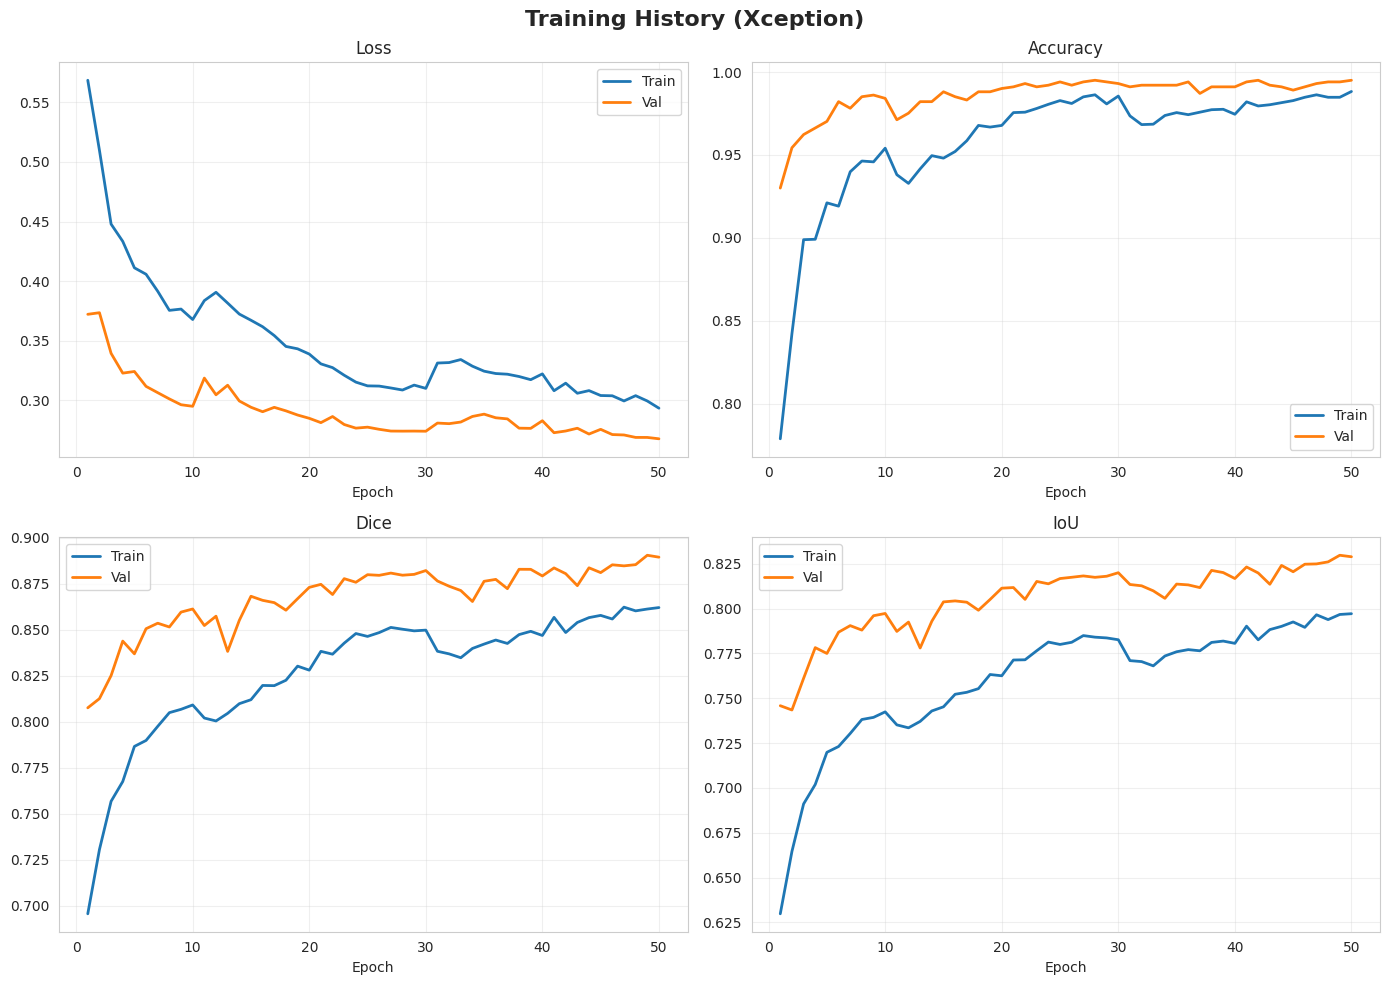

In [12]:
def plot_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Training History (Xception)', fontsize=16, fontweight='bold')
    metrics = [('loss', 'Loss'), ('acc', 'Accuracy'), ('dice', 'Dice'), ('iou', 'IoU')]
    epochs = range(1, len(history['train']) + 1)
    for ax, (key, title) in zip(axes.flat, metrics):
        ax.plot(epochs, [m[key] for m in history['train']], label='Train', lw=2)
        ax.plot(epochs, [m[key] for m in history['val']], label='Val', lw=2)
        ax.set_title(title); ax.set_xlabel('Epoch'); ax.legend(); ax.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

plot_history(history2)

Các biểu đồ lịch sử huấn luyện cho thấy hiệu năng trên tập Validation (đường màu cam) luôn vượt trội so với tập Train (đường màu xanh), minh chứng rõ ràng cho hiệu quả của chiến lược tăng cường dữ liệu mạnh (Data Augmentation) và Dropout trong việc ngăn chặn Overfitting, buộc mô hình phải học các đặc trưng cốt lõi từ dữ liệu khó. Đồng thời, xu hướng hội tụ ổn định của đường Loss và sự gia tăng liên tục của các chỉ số Dice/IoU (đặc biệt tại các điểm "bước nhảy" do Cosine Scheduler kích hoạt) khẳng định mô hình đã thoát khỏi các điểm tối ưu cục bộ và đạt được trạng thái tổng quát hóa tốt nhất tại các epoch cuối cùng mà không hề bị quá khớp.

## 10. Evaluation

In [13]:
# Load best model
ckpt = torch.load('best_xception_final.pth', map_location=Config.DEVICE)
model.load_state_dict(ckpt['model'])
print(f"Loaded best Xception model (IoU: {ckpt['iou']:.4f}, Dice: {ckpt['dice']:.4f})")

Loaded best Xception model (IoU: 0.8298, Dice: 0.8906)


In [14]:
@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    y_true_cls, y_pred_cls, y_true_seg, y_pred_seg = [], [], [], []
    for imgs, masks, labels in tqdm(loader, desc="Predicting"):
        imgs = imgs.to(device)
        pred_m, pred_c = model(imgs)
        y_true_cls.extend(labels.numpy())
        y_pred_cls.extend(torch.argmax(pred_c, dim=1).cpu().numpy())
        y_true_seg.append(masks)
        y_pred_seg.append((torch.sigmoid(pred_m) > 0.5).float().cpu())
    return np.array(y_true_cls), np.array(y_pred_cls), torch.cat(y_true_seg), torch.cat(y_pred_seg)

y_true_cls, y_pred_cls, y_true_seg, y_pred_seg = get_predictions(model, test_loader, Config.DEVICE)

Predicting: 100%|██████████| 1000/1000 [00:14<00:00, 71.06it/s]



CLASSIFICATION EVALUATION (Xception)
              precision    recall  f1-score   support

      glioma     0.9843    0.9882    0.9862       254
  meningioma     0.9900    0.9673    0.9785       306
    no_tumor     0.9790    1.0000    0.9894       140
   pituitary     0.9868    0.9967    0.9917       300

    accuracy                         0.9860      1000
   macro avg     0.9850    0.9880    0.9865      1000
weighted avg     0.9860    0.9860    0.9860      1000



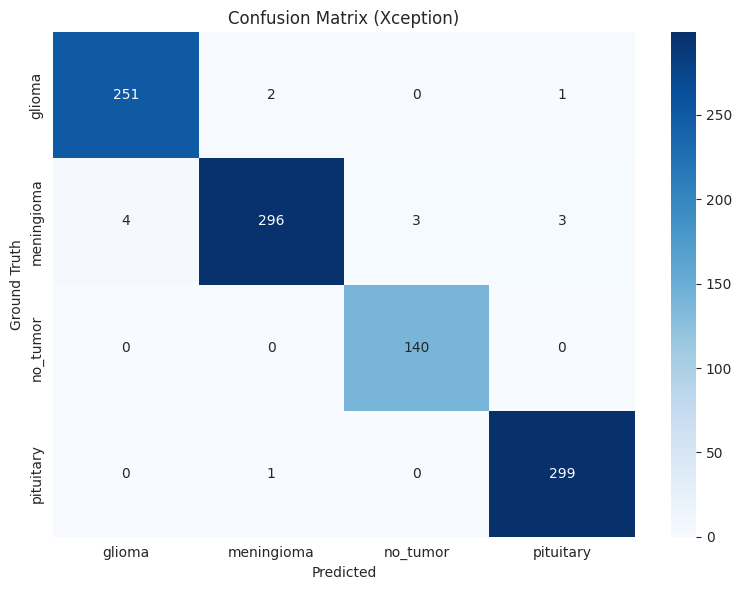

In [15]:
# Classification Report
print("\n" + "="*50 + "\nCLASSIFICATION EVALUATION (Xception)\n" + "="*50)
print(classification_report(y_true_cls, y_pred_cls, target_names=Config.CLASSES, digits=4))

cm = confusion_matrix(y_true_cls, y_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Config.CLASSES, yticklabels=Config.CLASSES)
plt.xlabel('Predicted'); plt.ylabel('Ground Truth'); plt.title('Confusion Matrix (Xception)')
plt.tight_layout(); plt.show()

Mô hình Xception đạt độ chính xác ấn tượng 98.60%, đặc biệt xuất sắc trong việc sàng lọc an toàn (đạt Recall 100% với nhóm "No Tumor"). Tuy nhiên, điểm yếu cốt lõi cần lưu ý là khả năng nhận diện U màng não (Meningioma) chưa tối ưu (bỏ sót 3.3% số ca), trong đó có những ca bị nhầm lẫn tai hại thành "Không u". Do đó, dù Xception hoạt động tốt, EfficientNet-B3 vẫn là lựa chọn ưu việt hơn cho bài toán này nhờ độ chính xác toàn diện và giảm thiểu tối đa rủi ro bỏ sót bệnh.


SEGMENTATION EVALUATION (Xception)
Mean IoU: 0.8116 | Std: 0.2043
Min: 0.0000 | Max: 1.0000


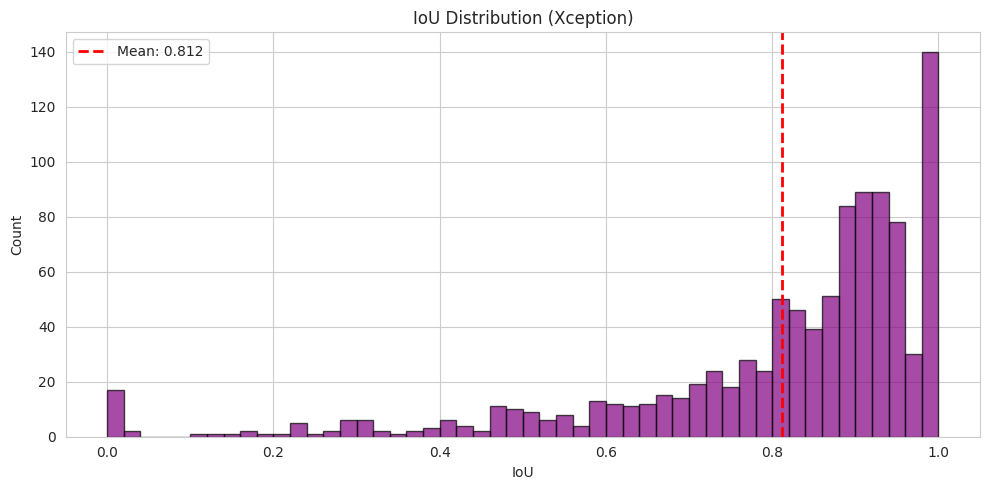

In [16]:
# Segmentation Evaluation
print("\n" + "="*50 + "\nSEGMENTATION EVALUATION (Xception)\n" + "="*50)
iou_scores = []
for i in range(y_true_seg.shape[0]):
    t, p = y_true_seg[i].view(-1), y_pred_seg[i].view(-1)
    inter = (p * t).sum().item()
    union = p.sum().item() + t.sum().item() - inter
    iou_scores.append((inter + 1e-6) / (union + 1e-6))

iou_scores = np.array(iou_scores)
print(f"Mean IoU: {np.mean(iou_scores):.4f} | Std: {np.std(iou_scores):.4f}")
print(f"Min: {np.min(iou_scores):.4f} | Max: {np.max(iou_scores):.4f}")

plt.figure(figsize=(10, 5))
plt.hist(iou_scores, bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(np.mean(iou_scores), color='r', linestyle='--', lw=2, label=f'Mean: {np.mean(iou_scores):.3f}')
plt.xlabel('IoU'); plt.ylabel('Count'); plt.title('IoU Distribution (Xception)'); plt.legend()
plt.tight_layout(); plt.show()

Kết quả thực nghiệm cho thấy hiệu năng phân đoạn của mô hình là rất ấn tượng với chỉ số Mean IoU đạt 0.8116, phản ánh khả năng định vị và khoanh vùng khối u sát với thực tế. Biểu đồ phân phối IoU cho thấy sự tập trung mật độ cao của các mẫu ở dải điểm xuất sắc (0.8 - 1.0) với đỉnh cao nhất tiệm cận mốc hoàn hảo, chứng tỏ trong đại đa số trường hợp, mô hình tái tạo lại hình dáng khối u gần như trùng khớp với nhãn chuẩn. Mặc dù sự hiện diện của một nhóm nhỏ các ca ngoại lai (outliers) có IoU thấp đã kéo giảm điểm trung bình chung, nhưng nhìn tổng thể, nhánh Segmentation của kiến trúc Multi-task Xception hoạt động ổn định và đáng tin cậy.

## 11. Sample Predictions

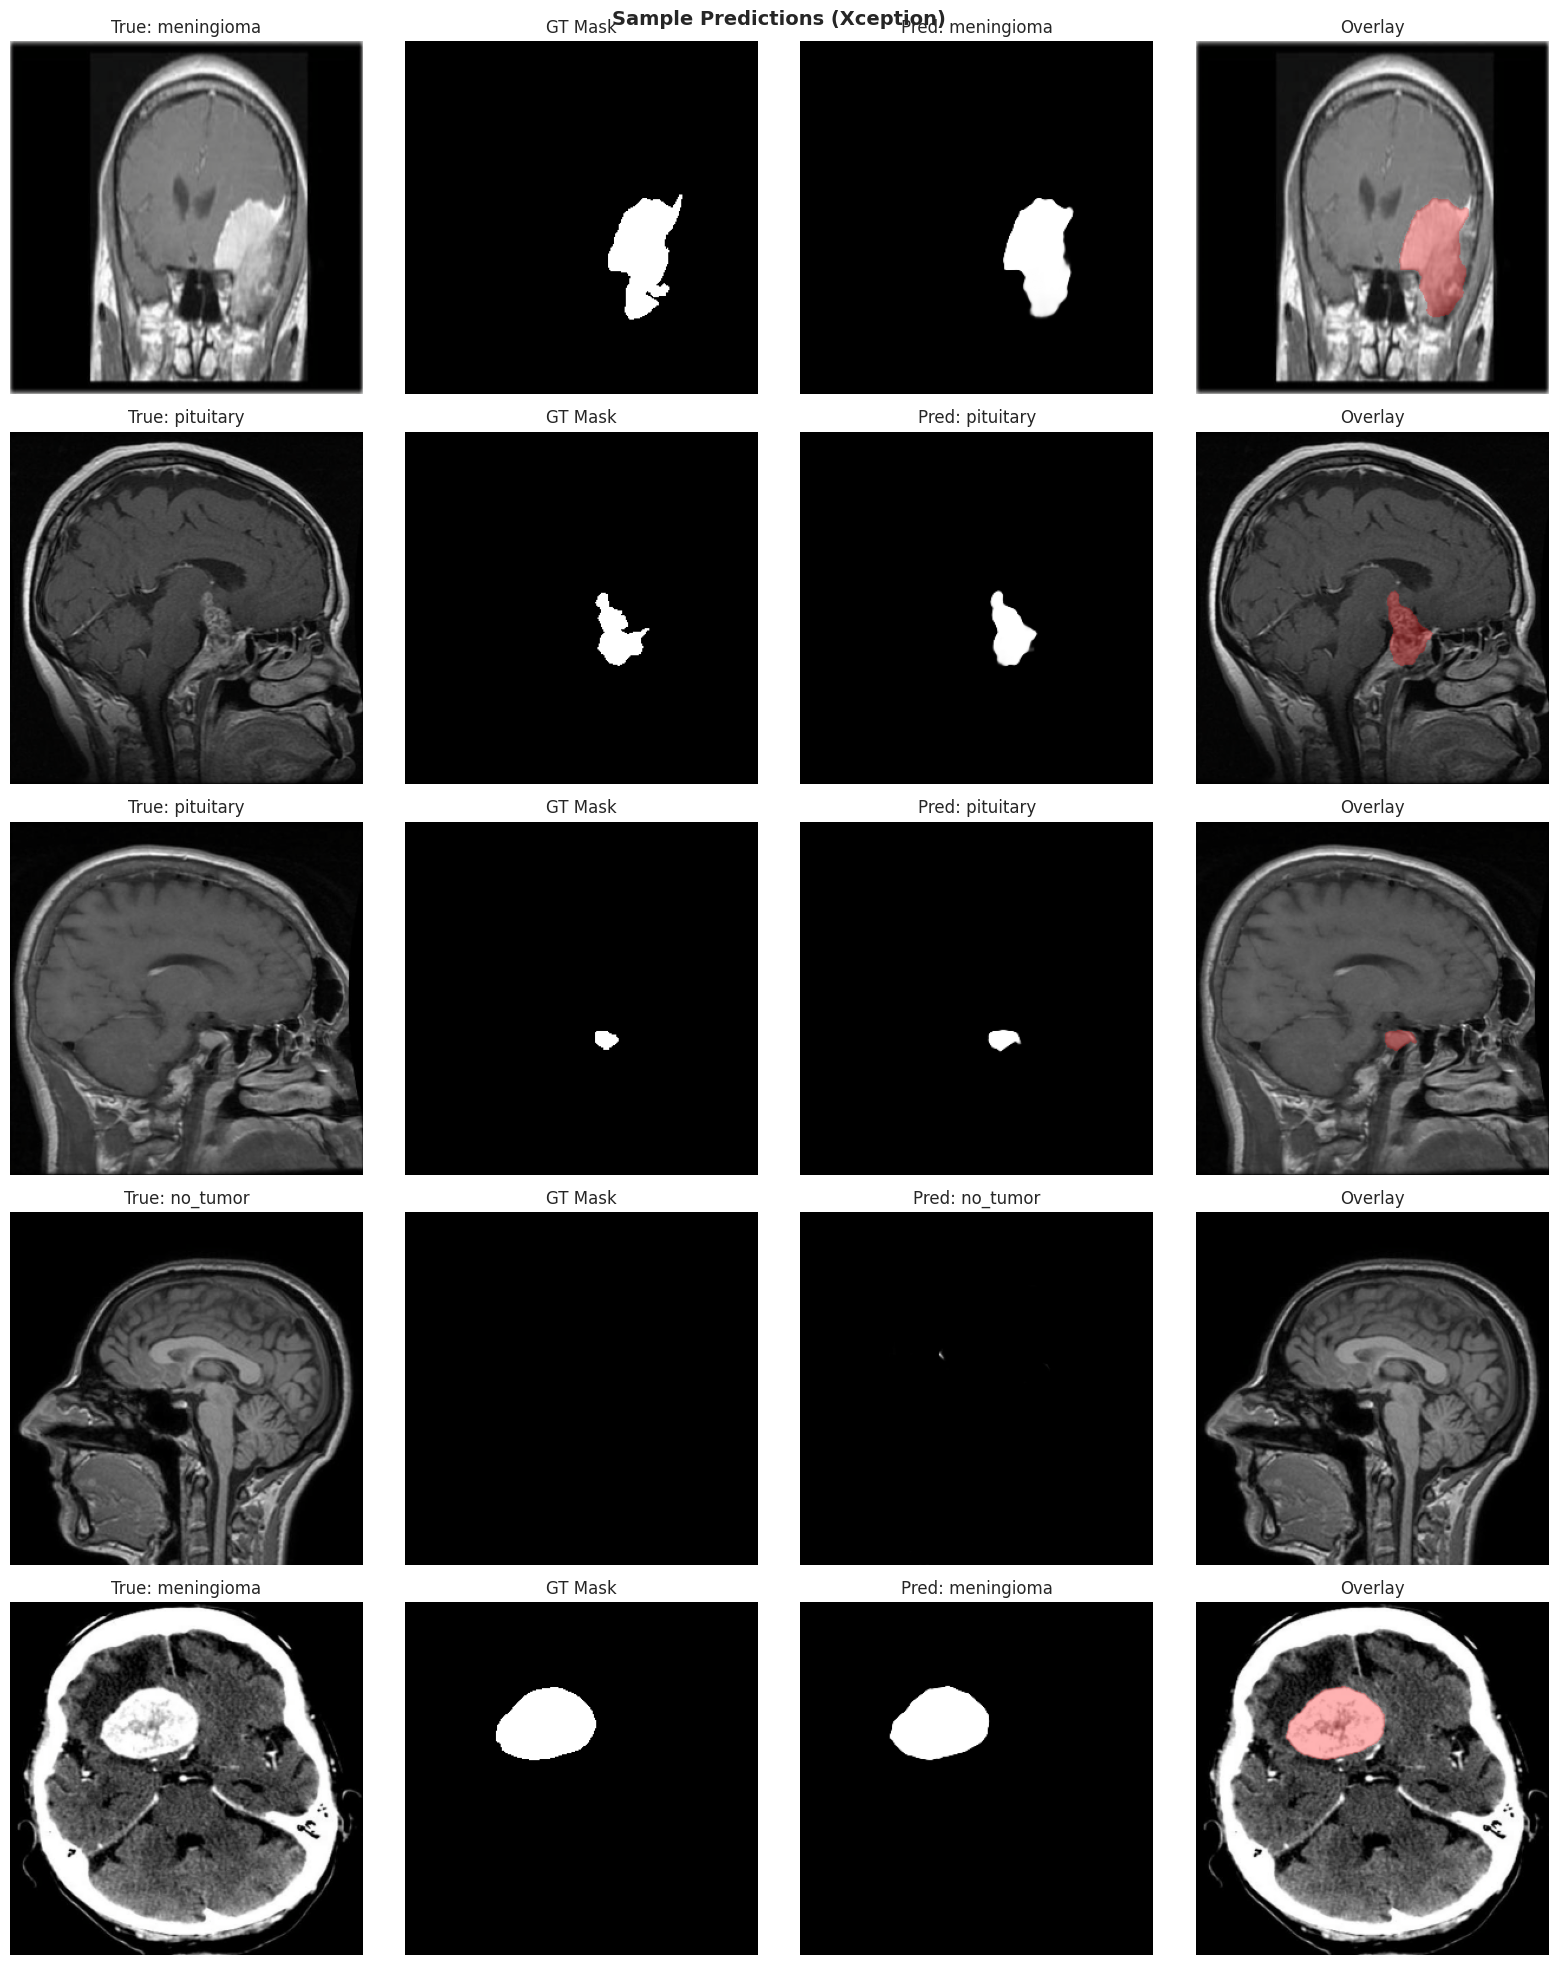

In [18]:
def visualize_samples(model, dataset, device, n=5):
    """Visualize random samples with segmentation results"""
    model.eval()
    indices = np.random.choice(len(dataset), n, replace=False)
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    mean, std = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    
    for i, idx in enumerate(indices):
        img, mask, label = dataset[idx]
        with torch.no_grad():
            pred_m, pred_c = model(img.unsqueeze(0).to(device))
            pred_m = torch.sigmoid(pred_m).cpu().squeeze()
            pred_label = torch.argmax(pred_c, dim=1).item()
        
        img_show = np.clip((img * std + mean).permute(1,2,0).numpy(), 0, 1)
        axes[i,0].imshow(img_show); axes[i,0].set_title(f"True: {Config.CLASSES[label]}"); axes[i,0].axis('off')
        axes[i,1].imshow(mask.squeeze(), cmap='gray'); axes[i,1].set_title("GT Mask"); axes[i,1].axis('off')
        axes[i,2].imshow(pred_m, cmap='gray'); axes[i,2].set_title(f"Pred: {Config.CLASSES[pred_label]}"); axes[i,2].axis('off')
        overlay = img_show.copy(); overlay[pred_m > 0.5] = [1, 0, 0]
        axes[i,3].imshow(np.clip(0.7*img_show + 0.3*overlay, 0, 1)); axes[i,3].set_title("Overlay"); axes[i,3].axis('off')
    plt.suptitle('Sample Predictions (Xception)', fontsize=14, fontweight='bold')
    plt.tight_layout(); plt.show()

test_dataset = BRISCDataset(test_df, get_val_transforms(Config.IMG_SIZE))
visualize_samples(model, test_dataset, Config.DEVICE, n=5)


DETAILED VISUALIZATION BY CLASS (Xception)


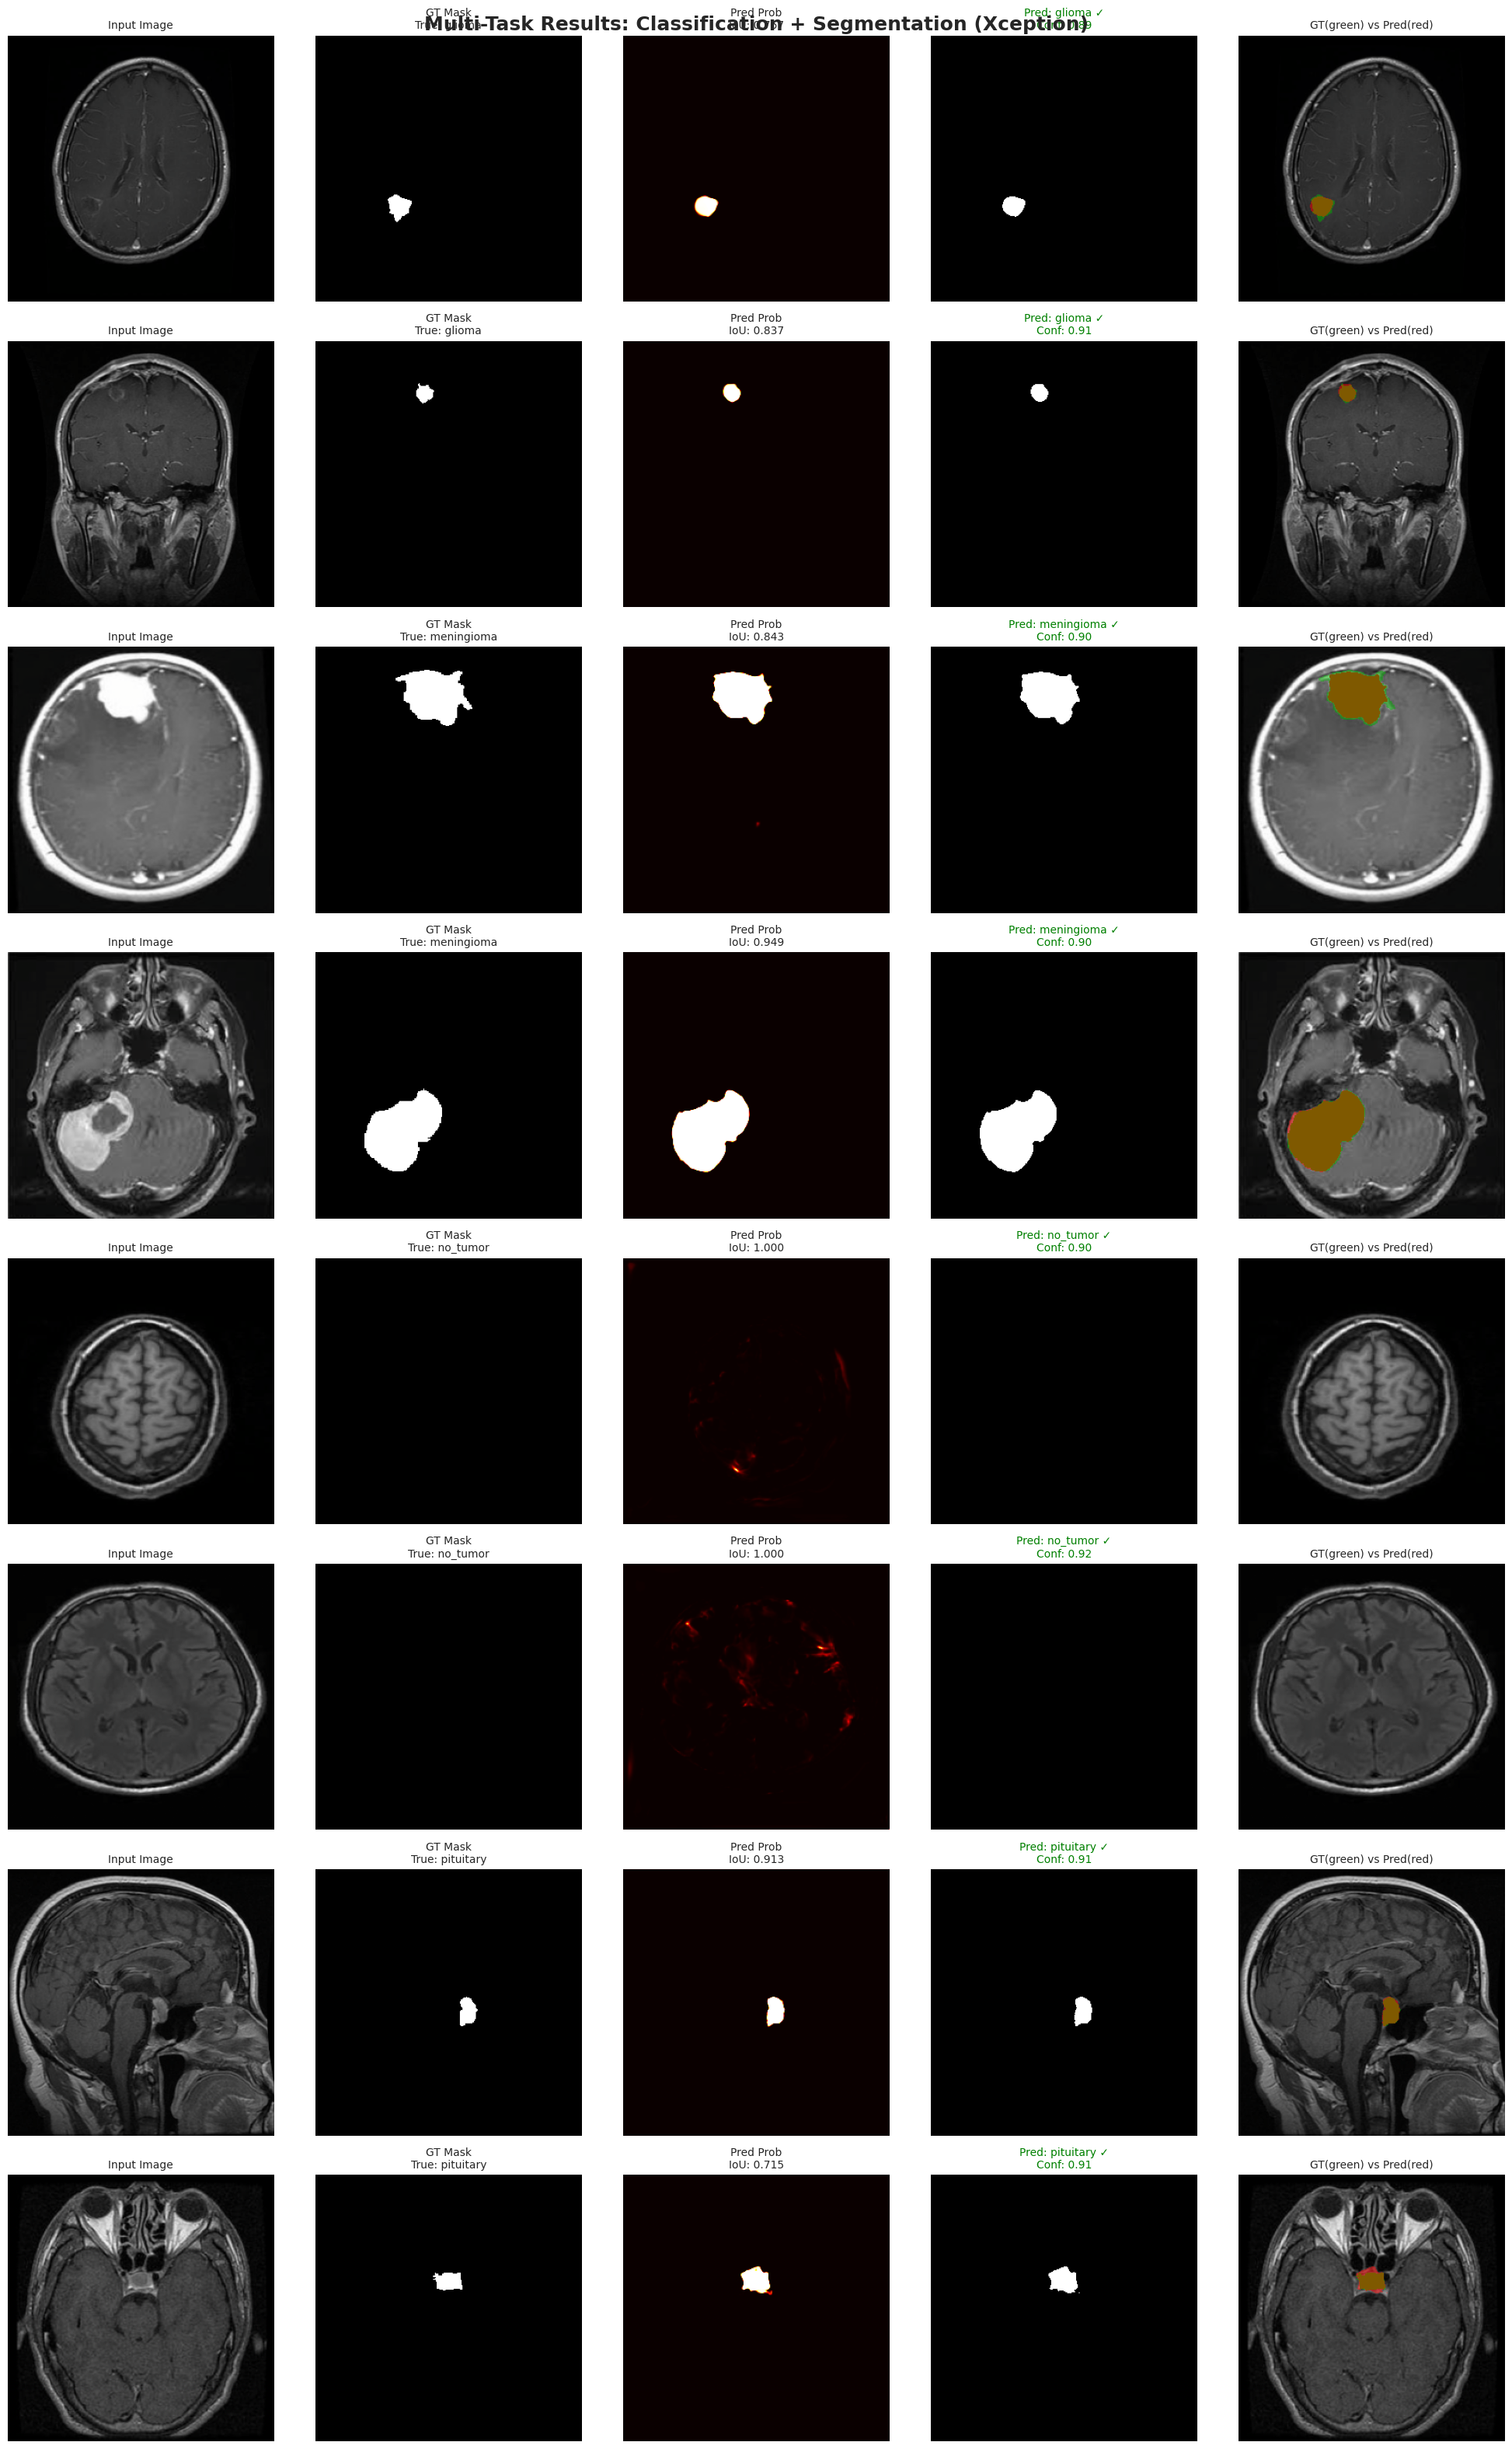

In [19]:
# ============ DETAILED VISUALIZATION ============
def visualize_by_class(model, dataset, device, samples_per_class=2):
    """Visualize samples grouped by class with both segmentation and classification results"""
    model.eval()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    
    # Group indices by class
    class_indices = {i: [] for i in range(Config.NUM_CLASSES)}
    for idx in range(len(dataset)):
        _, _, label = dataset[idx]
        class_indices[label.item()].append(idx)
    
    total_samples = samples_per_class * Config.NUM_CLASSES
    fig, axes = plt.subplots(total_samples, 5, figsize=(20, 4*total_samples))
    fig.suptitle('Multi-Task Results: Classification + Segmentation (Xception)', fontsize=18, fontweight='bold')
    
    row = 0
    for cls_id, cls_name in enumerate(Config.CLASSES):
        indices = np.random.choice(class_indices[cls_id], min(samples_per_class, len(class_indices[cls_id])), replace=False)
        
        for idx in indices:
            img, mask, label = dataset[idx]
            with torch.no_grad():
                pred_m, pred_c = model(img.unsqueeze(0).to(device))
                pred_prob = torch.sigmoid(pred_m).cpu().squeeze()
                pred_binary = (pred_prob > 0.5).float()
                pred_label = torch.argmax(pred_c, dim=1).item()
                confidence = torch.softmax(pred_c, dim=1).max().item()
            
            # Calculate IoU for this sample
            inter = (pred_binary * mask.squeeze()).sum().item()
            union = pred_binary.sum().item() + mask.squeeze().sum().item() - inter
            iou = (inter + 1e-6) / (union + 1e-6)
            
            img_show = np.clip((img * std + mean).permute(1,2,0).numpy(), 0, 1)
            
            axes[row,0].imshow(img_show)
            axes[row,0].set_title(f'Input Image', fontsize=10)
            axes[row,0].axis('off')
            
            axes[row,1].imshow(mask.squeeze(), cmap='gray')
            axes[row,1].set_title(f'GT Mask\nTrue: {cls_name}', fontsize=10)
            axes[row,1].axis('off')
            
            axes[row,2].imshow(pred_prob, cmap='hot')
            axes[row,2].set_title(f'Pred Prob\nIoU: {iou:.3f}', fontsize=10)
            axes[row,2].axis('off')
            
            cls_correct = '✓' if pred_label == label.item() else '✗'
            color = 'green' if pred_label == label.item() else 'red'
            axes[row,3].imshow(pred_binary, cmap='gray')
            axes[row,3].set_title(f'Pred: {Config.CLASSES[pred_label]} {cls_correct}\nConf: {confidence:.2f}', fontsize=10, color=color)
            axes[row,3].axis('off')
            
            overlay = img_show.copy()
            gt_mask_np = mask.squeeze().numpy()
            pred_mask_np = pred_binary.numpy()
            overlay[gt_mask_np > 0] = [0, 0.7, 0]
            overlay_pred = img_show.copy()
            overlay_pred[pred_mask_np > 0] = [1, 0, 0]
            combined = 0.5 * overlay + 0.5 * overlay_pred
            axes[row,4].imshow(np.clip(combined, 0, 1))
            axes[row,4].set_title('GT(green) vs Pred(red)', fontsize=10)
            axes[row,4].axis('off')
            
            row += 1
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*50 + "\nDETAILED VISUALIZATION BY CLASS (Xception)\n" + "="*50)
visualize_by_class(model, test_dataset, Config.DEVICE, samples_per_class=2)


BEST & WORST PREDICTIONS (Xception)


Calculating IoUs: 100%|██████████| 1000/1000 [00:16<00:00, 62.43it/s]


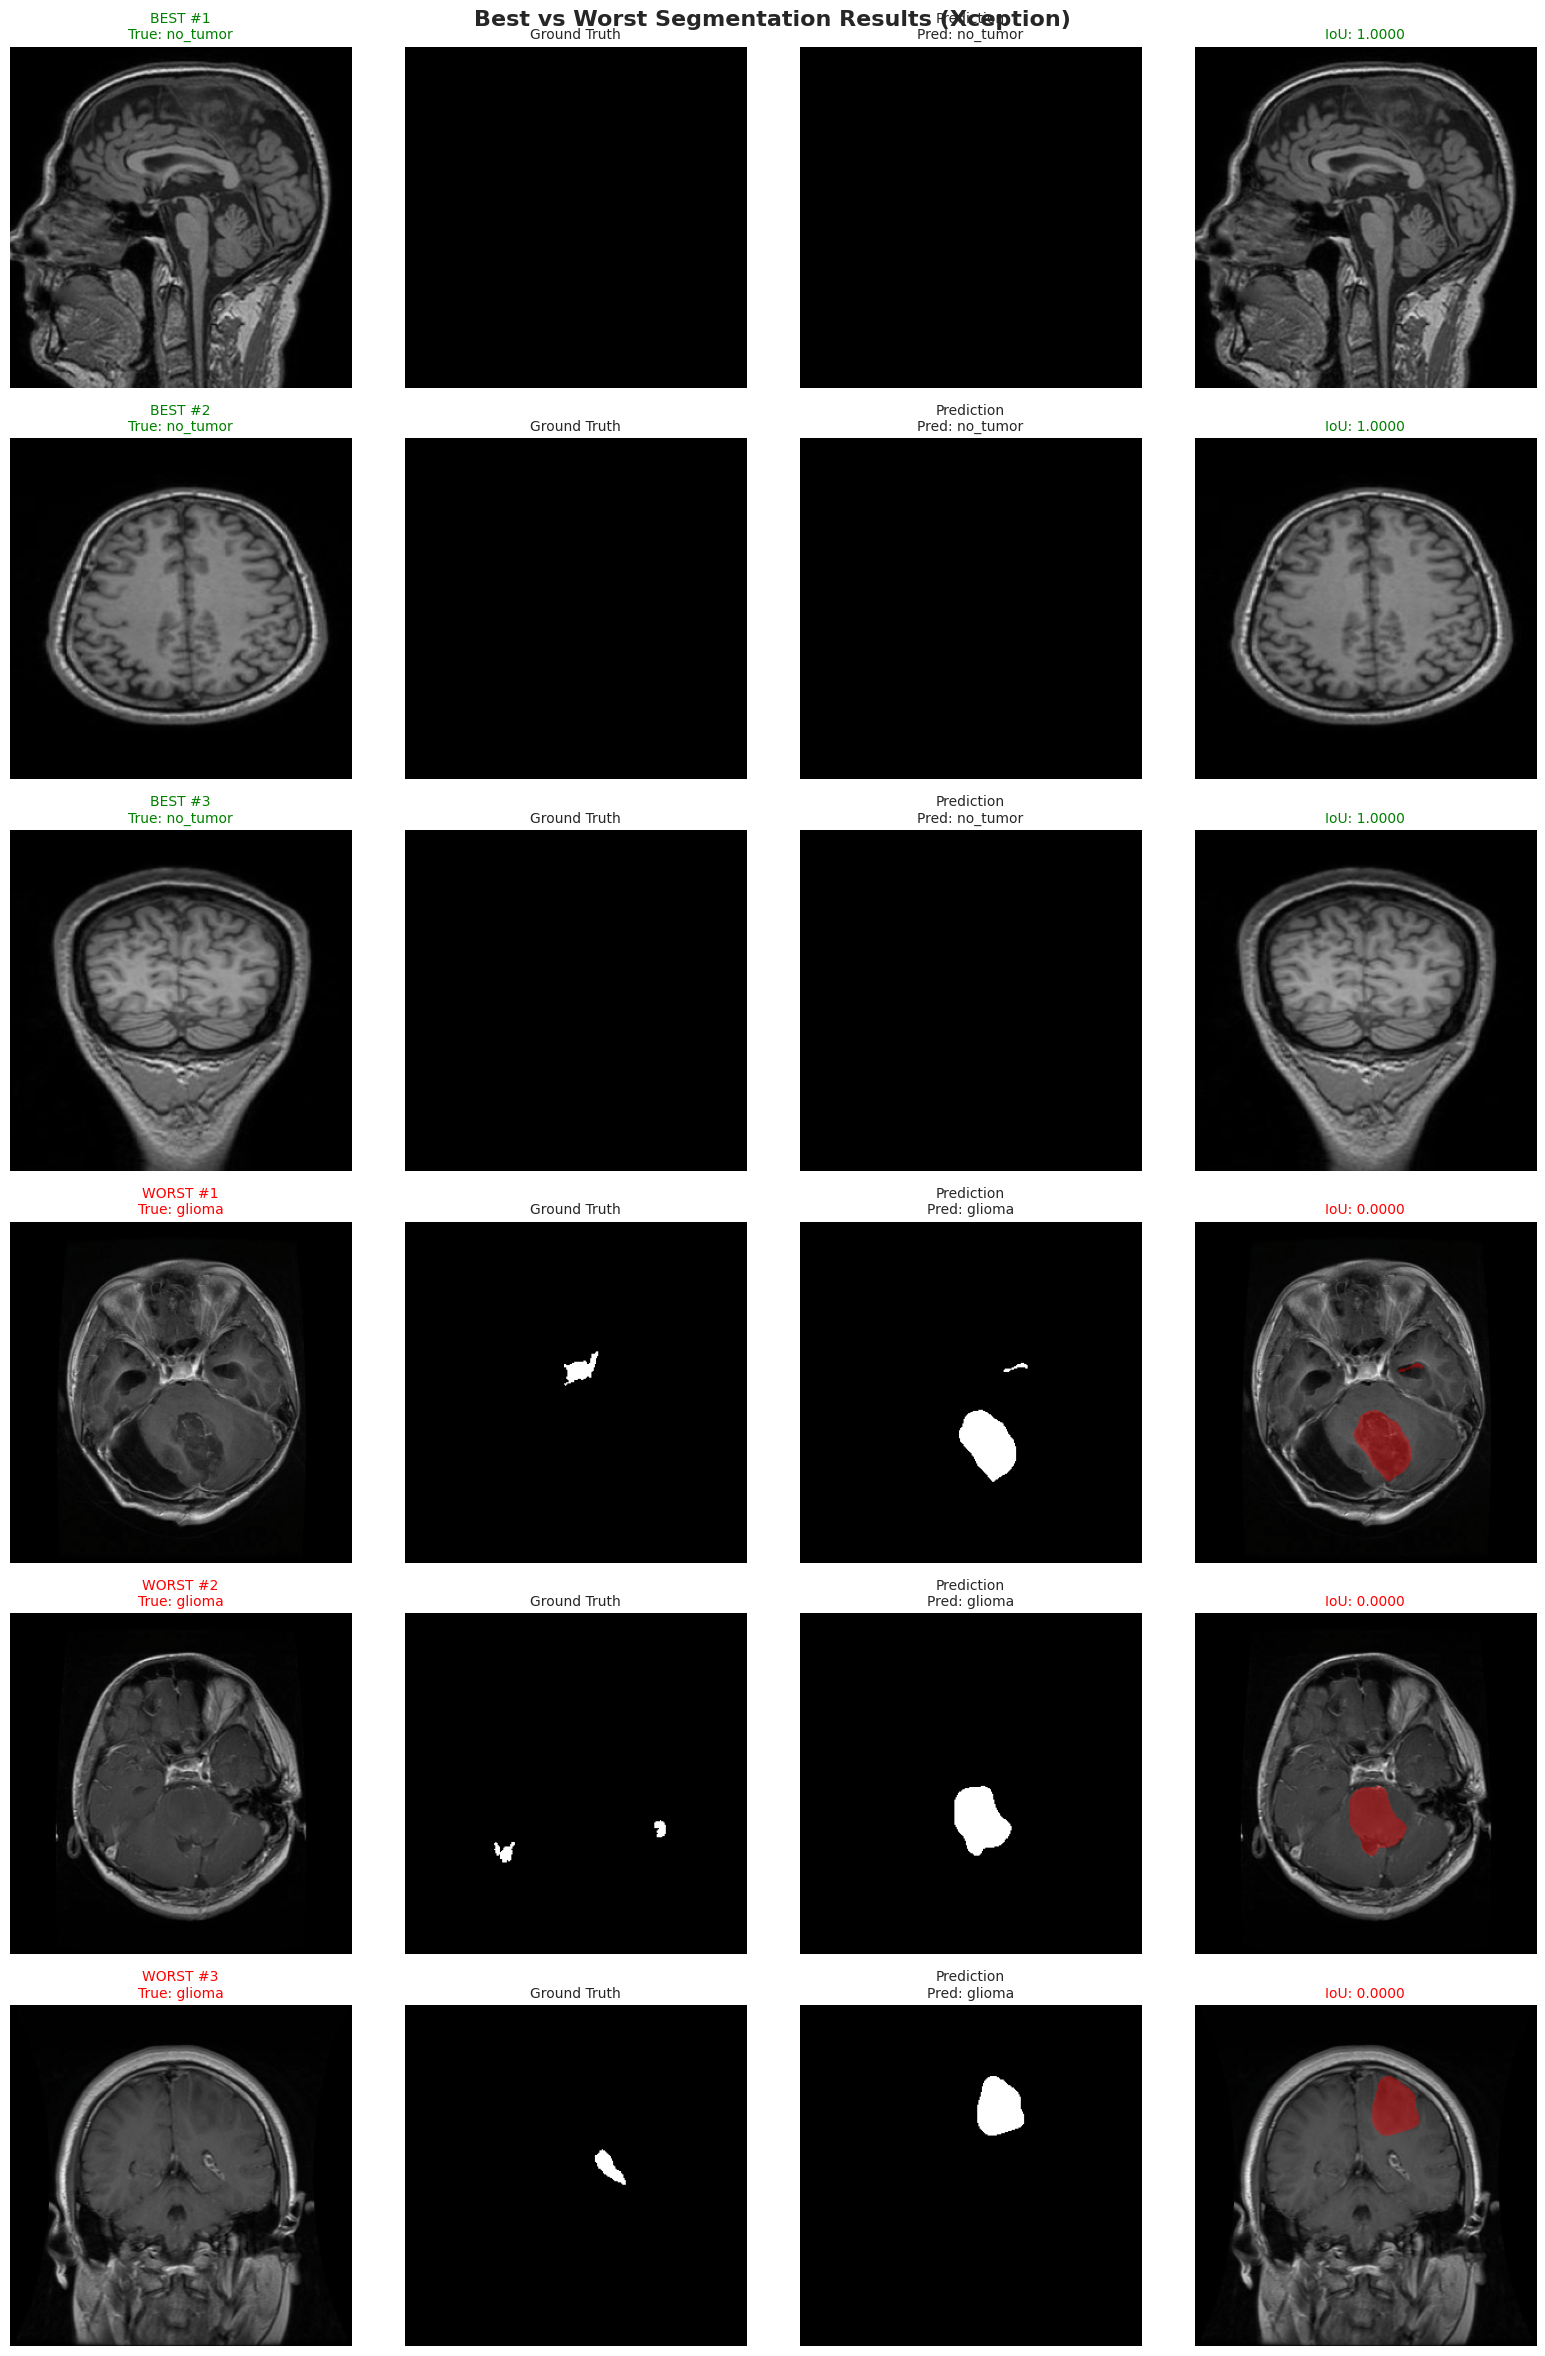

In [20]:
# ============ BEST & WORST PREDICTIONS ============
def visualize_best_worst(model, dataset, device, n=3):
    """Visualize best and worst segmentation predictions"""
    model.eval()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    
    # Calculate IoU for all samples
    all_ious = []
    for idx in tqdm(range(len(dataset)), desc="Calculating IoUs"):
        img, mask, label = dataset[idx]
        with torch.no_grad():
            pred_m, pred_c = model(img.unsqueeze(0).to(device))
            pred_binary = (torch.sigmoid(pred_m) > 0.5).float().cpu().squeeze()
            pred_label = torch.argmax(pred_c, dim=1).item()
        
        inter = (pred_binary * mask.squeeze()).sum().item()
        union = pred_binary.sum().item() + mask.squeeze().sum().item() - inter
        iou = (inter + 1e-6) / (union + 1e-6)
        all_ious.append((idx, iou, label.item(), pred_label))
    
    # Sort by IoU
    all_ious.sort(key=lambda x: x[1])
    worst = all_ious[:n]
    best = all_ious[-n:][::-1]
    
    fig, axes = plt.subplots(2*n, 4, figsize=(16, 4*2*n))
    fig.suptitle('Best vs Worst Segmentation Results (Xception)', fontsize=16, fontweight='bold')
    
    for i, (idx, iou, true_label, pred_label) in enumerate(best + worst):
        img, mask, label = dataset[idx]
        with torch.no_grad():
            pred_m, _ = model(img.unsqueeze(0).to(device))
            pred_prob = torch.sigmoid(pred_m).cpu().squeeze()
            pred_binary = (pred_prob > 0.5).float()
        
        img_show = np.clip((img * std + mean).permute(1,2,0).numpy(), 0, 1)
        
        title_prefix = 'BEST' if i < n else 'WORST'
        color = 'green' if i < n else 'red'
        
        axes[i,0].imshow(img_show)
        axes[i,0].set_title(f'{title_prefix} #{i%n+1}\nTrue: {Config.CLASSES[true_label]}', fontsize=10, color=color)
        axes[i,0].axis('off')
        
        axes[i,1].imshow(mask.squeeze(), cmap='gray')
        axes[i,1].set_title('Ground Truth', fontsize=10)
        axes[i,1].axis('off')
        
        axes[i,2].imshow(pred_binary, cmap='gray')
        axes[i,2].set_title(f'Prediction\nPred: {Config.CLASSES[pred_label]}', fontsize=10)
        axes[i,2].axis('off')
        
        overlay = img_show.copy()
        overlay[pred_binary.numpy() > 0] = [1, 0, 0]
        axes[i,3].imshow(np.clip(0.6*img_show + 0.4*overlay, 0, 1))
        axes[i,3].set_title(f'IoU: {iou:.4f}', fontsize=10, color=color)
        axes[i,3].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*50 + "\nBEST & WORST PREDICTIONS (Xception)\n" + "="*50)
visualize_best_worst(model, test_dataset, Config.DEVICE, n=3)

In [21]:
print("\n" + "="*50 + "\nTRAINING COMPLETE! (Xception Encoder)\n" + "="*50)
print(f"Model: {Config.ENCODER_NAME}")
print(f"Image Size: {Config.IMG_SIZE}x{Config.IMG_SIZE}")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


TRAINING COMPLETE! (Xception Encoder)
Model: xception
Image Size: 299x299
Total Parameters: 30.49M
